<a href="https://colab.research.google.com/github/NeuralNetGeek/monkeypox-diagnosis/blob/main/Monkey_Pox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

DATA COLLECTION

The dataset was sourced from https://www.kaggle.com/datasets/muhammad4hmed/monkeypox-patients-dataset

DATA CLEANING, EXPLORATION AND PREPROCESSING

In [111]:
cols = ['Patient_ID', 'Systemic Illness', 'Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'Sexually Transmitted Infection', 'MonkeyPox']
df = pd.read_csv('monkey.data.csv')
df.columns = cols
df.drop(['Patient_ID', 'Systemic Illness'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)

df['Genital Symptoms'] = df[['Rectal Pain', 'Penile Oedema']].max(axis=1)
df['Throat Symptoms'] = df['Sore Throat'].copy()

features = ['Genital Symptoms', 'Throat Symptoms', 'Oral Lesions', 'Solitary Lesion', 'HIV Infection']

df[features] = df[features].astype(int)

df['Monkey_Pox'] = df['MonkeyPox'].map({'Positive': 1, 'Negative': 0})
df = df.drop(['Rectal Pain', 'Penile Oedema', 'Sore Throat', 'Swollen Tonsils', 'Sexually Transmitted Infection', 'MonkeyPox'], axis=1)

df.head(10)

,Oral Lesions,Solitary Lesion,HIV Infection,Genital Symptoms,Throat Symptoms,Monkey_Pox
0,1,0,0,1,1,0
1,1,0,1,1,0,1
2,0,0,1,1,1,1
3,0,1,1,1,0,1
4,0,0,1,1,1,1
5,0,0,0,0,1,0
6,0,0,1,0,1,1
7,1,1,0,1,1,1
8,1,0,0,1,1,1
9,1,1,1,1,0,0


In [112]:
df['Monkey_Pox'].value_counts()

,count
Monkey_Pox,
0,256
1,256


In [113]:
features_encoded = ['Genital Symptoms', 'Throat Symptoms', 'Oral Lesions', 'Solitary Lesion', 'HIV Infection']
target = 'Monkey_Pox'

X = df[features_encoded]
y = df[target]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

TRAIN, VALID AND TEST

In [117]:
def evaluate_classifiers(models, X, y, show_reports=True):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    summary = []

    for name, model in models.items():
        try:
            cv_scores = cross_validate(model, X, y, cv=skf, scoring='f1')
            mean_cv_score = cv_scores['test_score'].mean()

            model.fit(X, y)
            y_pred = model.predict(X)

            acc = accuracy_score(y, y_pred)
            prec = precision_score(y, y_pred, zero_division=0)
            rec = recall_score(y, y_pred, zero_division=0)
            f1 = f1_score(y, y_pred, zero_division=0)

            roc_auc = np.nan
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X)[:, 1]
                if len(np.unique(y)) > 1:
                    roc_auc = roc_auc_score(y, y_prob)

            summary.append({
                'Model': name,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC-AUC': roc_auc,
                'Cross-Validation F1 Mean': mean_cv_score
            })

            if show_reports:
                print(f"\nModel: {name}")
                print(f"Cross-Validation F1 Mean: {mean_cv_score:.4f}")
                print("Confusion Matrix:")
                print(confusion_matrix(y, y_pred))
                print("\nClassification Report:")
                print(classification_report(y, y_pred, zero_division=0))

        except Exception as e:
            print(f"\nError with {name}: {e}")
            summary.append({
                'Model': name,
                'Accuracy': np.nan,
                'Precision': np.nan,
                'Recall': np.nan,
                'F1 Score': np.nan,
                'ROC-AUC': np.nan,
                'Cross-Validation F1 Mean': np.nan
            })

    return pd.DataFrame(summary)

models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(C=10, kernel='poly', class_weight='balanced', probability=True),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
}

results = evaluate_classifiers(models, X_train_scaled, y_train)
print("\nModel Performance Summary:")
print(results)


Model: Logistic Regression
Cross-Validation F1 Mean: 0.4334
Confusion Matrix:
[[80 73]
 [74 79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       153
           1       0.52      0.52      0.52       153

    accuracy                           0.52       306
   macro avg       0.52      0.52      0.52       306
weighted avg       0.52      0.52      0.52       306


Model: K-Nearest Neighbors
Cross-Validation F1 Mean: 0.5159
Confusion Matrix:
[[109  44]
 [ 83  70]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.71      0.63       153
           1       0.61      0.46      0.52       153

    accuracy                           0.58       306
   macro avg       0.59      0.58      0.58       306
weighted avg       0.59      0.58      0.58       306


Model: Naive Bayes
Cross-Validation F1 Mean: 0.4420
Confusion Matrix:
[[75 78]
 [67 86]]

Classif

In [118]:
def evaluate_model(model, X_valid, y_valid):
    y_pred = model.predict(X_valid)

    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred, zero_division=0)
    rec = recall_score(y_valid, y_pred, zero_division=0)
    f1 = f1_score(y_valid, y_pred, zero_division=0)

    y_prob = None
    roc_auc = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_valid)[:, 1]
        if len(np.unique(y_valid)) > 1:
            roc_auc = roc_auc_score(y_valid, y_prob)


    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

svm_valid_results = evaluate_model(models["Support Vector Machine"], X_valid_scaled, y_valid)
rf_valid_results = evaluate_model(models["Random Forest"], X_valid, y_valid)
hist_valid_results = evaluate_model(models["HistGradientBoosting"], X_valid, y_valid)

comparison_df = pd.DataFrame({
    "Support Vector Machine": svm_valid_results,
    "Random Forest": rf_valid_results,
    "HistGradientBoosting": hist_valid_results
})

comparison_df = comparison_df.T

print("\nValidation Set Performance Comparison:")
print(comparison_df.round(4))


Validation Set Performance Comparison:
                        Accuracy  Precision  Recall  F1 Score  ROC-AUC
Support Vector Machine    0.3883     0.4068  0.4615    0.4324   0.6144
Random Forest             0.5243     0.5283  0.5385    0.5333   0.5241
HistGradientBoosting      0.5243     0.5283  0.5385    0.5333   0.5241


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


MonkeyPox HGB Model - SHAP Summary Plot:


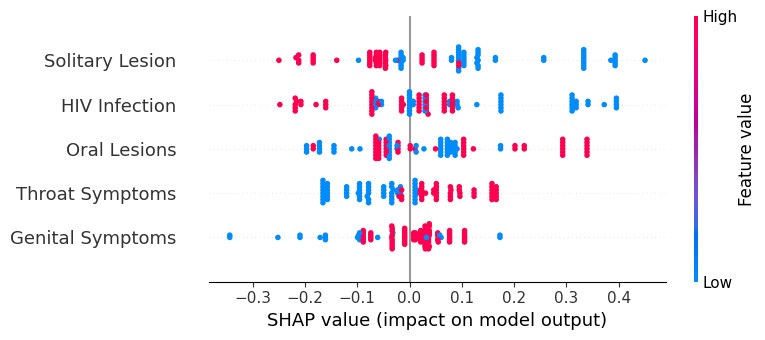

In [119]:
explainer_hgb = shap.TreeExplainer(models["HistGradientBoosting"], X_train_scaled)
shap_values_hgb = explainer_hgb.shap_values(X_valid_scaled)

print("MonkeyPox HGB Model - SHAP Summary Plot:")
shap.summary_plot(shap_values_hgb, X_valid_scaled, feature_names=features_encoded)